In [1]:
import pandas as pd
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from tabulate import tabulate
from src import camvid
from src import evaluate
from src import predict
from src import predict_video
from src.tiramisu import tiramisu
from src.callbacks import PlotMetrics
from src.utils import history_to_results
%matplotlib inline

Using TensorFlow backend.
/usr/local/anaconda5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# the location to save coarse training weights to
coarse_weights = 'models/Tiramisu103-CamVid11-coarse.h5'
# the location to save fine training weights to
fine_weights = 'models/Tiramisu103-CamVid11-fine.h5'

In [3]:
# the size to reshape images to before transformation
target_size = (360, 480)
# the size to crop images to for coarse training
coarse_crop = (224, 224)
# the batch size during coarse training
coarse_batch = 3
# the size to crop images to for fine tune training
fine_crop = (352, 480)
# the batch size during fine training
fine_batch = 1

# Coarse Tuning

In [4]:
camvid11 = camvid.CamVid(
    mapping=camvid.load_mapping(),
    target_size=target_size,
    crop_size=coarse_crop,
    batch_size=coarse_batch,
    horizontal_flip=True,
    ignored_labels=['Void'],
)
generators = camvid11.generators()

Found 367 images belonging to 1 classes.
Found 367 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 233 images belonging to 1 classes.
Found 233 images belonging to 1 classes.


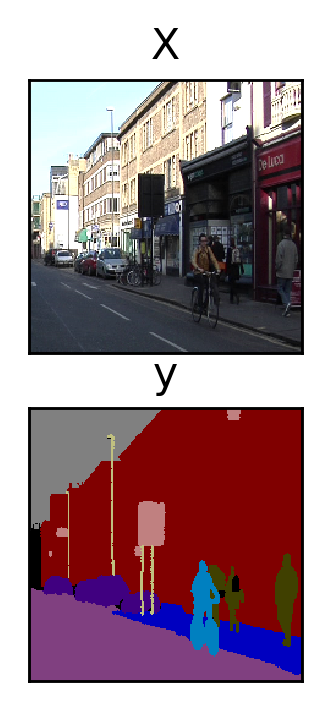

In [5]:
# get the next X, y training tuple
X, y = next(generators['train'])
# transform the onehot vector to an image
y = camvid11.unmap(y)
# plot the images
_ = camvid.plot(X=X[0], y=y[0], order=['X', 'y'])

In [6]:
# build the model for the image shape and number of labels
model = tiramisu.tiramisu((*coarse_crop, 3), camvid11.n,
    class_weights=camvid11.class_mask,
    learning_rate=1e-3,
)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Tiramisu_input (InputLayer)     (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
pixel_norm (Lambda)             (None, 224, 224, 3)  0           Tiramisu_input[0][0]             
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 48) 1344        pixel_norm[0][0]                 
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 48) 192         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

In [7]:
callbacks = [
    EarlyStopping(monitor='val_categorical_accuracy', patience=100),
    LearningRateScheduler(lambda _, lr: 0.995 * lr),
    ModelCheckpoint(coarse_weights, 
        monitor='val_categorical_accuracy', 
        save_best_only=True, 
        save_weights_only=True, 
        mode='max'
    ),
    PlotMetrics(),
]

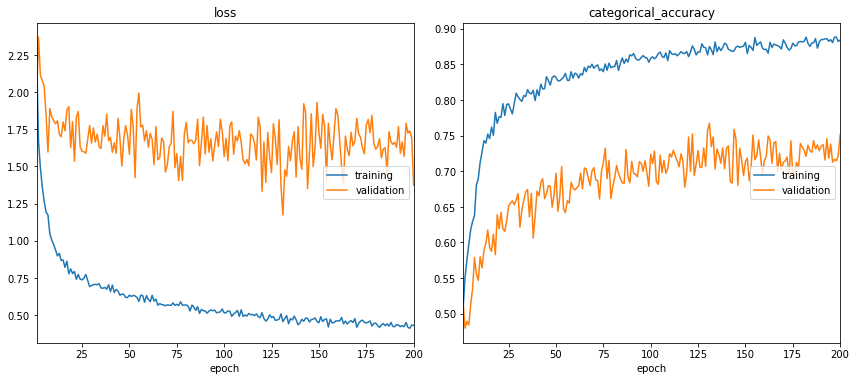

In [8]:
# fit the model with the data. divide the steps per epoch by the batch size
history = model.fit_generator(generators['train'],
    epochs=200,
    steps_per_epoch=int(367 / coarse_batch),
    validation_data=generators['val'],
    validation_steps=101,
    callbacks=callbacks,
    verbose=0
)

In [9]:
history_to_results(history)

train       val
categorical_accuracy  0.884032  0.751403
loss                  0.429835  1.373146

## Test Metrics

In [10]:
model.load_weights(coarse_weights)

In [11]:
metrics = evaluate.evaluate(model, generators['test'], 233,
    mask=camvid11.class_mask, 
    label_map=camvid11.label_to_discrete_map
)
metrics.to_csv(coarse_weights + '.csv')
metrics

100%|██████████| 233/233 [01:28<00:00,  2.64step/s]


Test
Accuracy                 0.817985
Mean Per Class Accuracy  0.580301
Mean I/U                 0.447836
Bicyclist                0.134511
Building                 0.637507
Car                      0.549888
Column_Pole              0.212855
Fence                    0.155217
Pedestrian               0.300435
Road                     0.838999
Sidewalk                 0.555561
SignSymbol               0.146439
Sky                      0.773507
VegetationMisc           0.621277

In [12]:
print(tabulate(metrics, tablefmt='pipe', headers=('Metric', 'Value')))

| Metric                  |    Value |
|:------------------------|---------:|
| Accuracy                | 0.817985 |
| Mean Per Class Accuracy | 0.580301 |
| Mean I/U                | 0.447836 |
| Bicyclist               | 0.134511 |
| Building                | 0.637507 |
| Car                     | 0.549888 |
| Column_Pole             | 0.212855 |
| Fence                   | 0.155217 |
| Pedestrian              | 0.300435 |
| Road                    | 0.838999 |
| Sidewalk                | 0.555561 |
| SignSymbol              | 0.146439 |
| Sky                     | 0.773507 |
| VegetationMisc          | 0.621277 |


## Qualitative Results

### Train

In [13]:
X, y, p = predict.predict(model, generators['train'], camvid11)

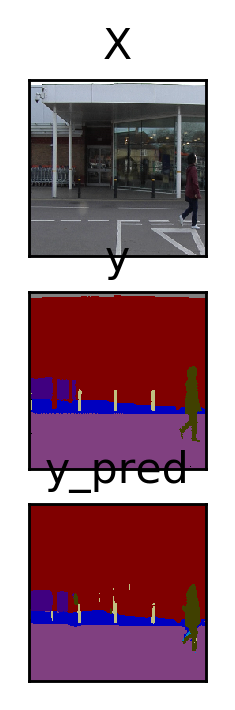

In [14]:
_ = camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

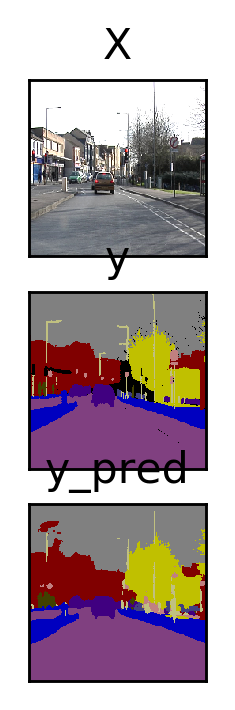

In [15]:
_ = camvid.plot(X=X[1], y=y[1], y_pred=p[1], order=['X', 'y', 'y_pred'])

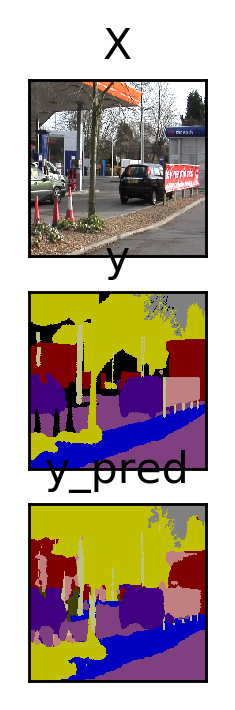

In [16]:
_ = camvid.plot(X=X[2], y=y[2], y_pred=p[2], order=['X', 'y', 'y_pred'])

### Validation

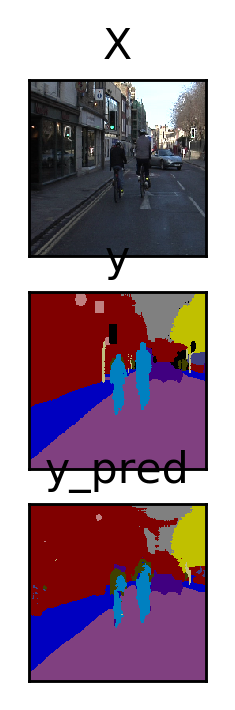

In [17]:
X, y, p = predict.predict(model, generators['val'], camvid11)
_ = camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

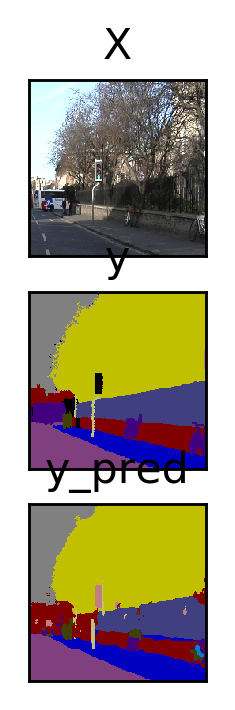

In [18]:
X, y, p = predict.predict(model, generators['val'], camvid11)
_ = camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

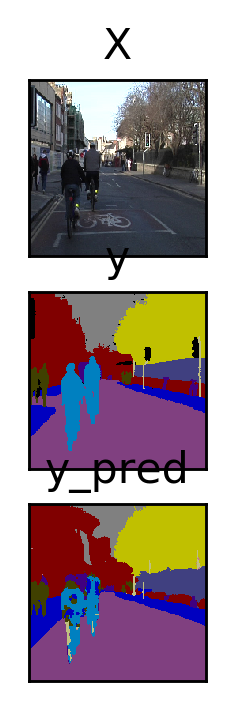

In [19]:
X, y, p = predict.predict(model, generators['val'], camvid11)
_ = camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

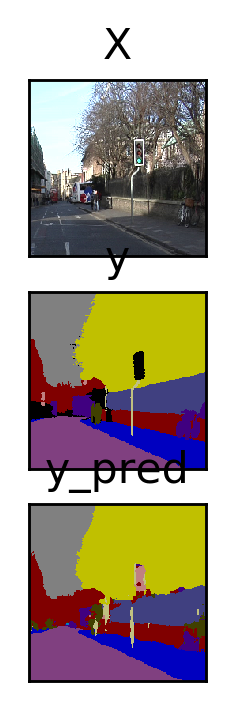

In [20]:
X, y, p = predict.predict(model, generators['val'], camvid11)
_ = camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

### Test

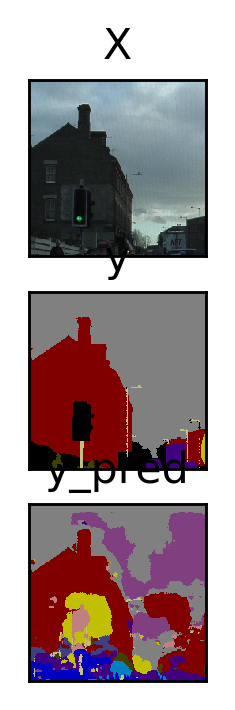

In [21]:
X, y, p = predict.predict(model, generators['test'], camvid11)
_ = camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

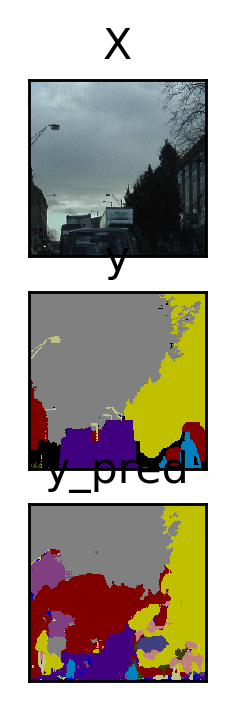

In [22]:
X, y, p = predict.predict(model, generators['test'], camvid11)
_ = camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

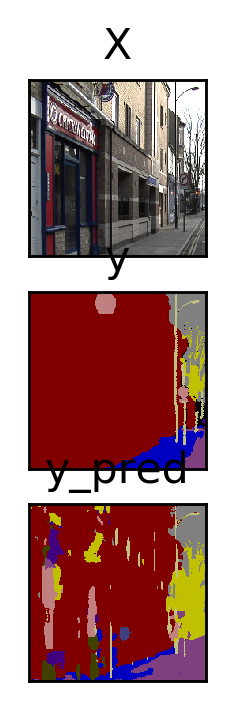

In [23]:
X, y, p = predict.predict(model, generators['test'], camvid11)
_ = camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

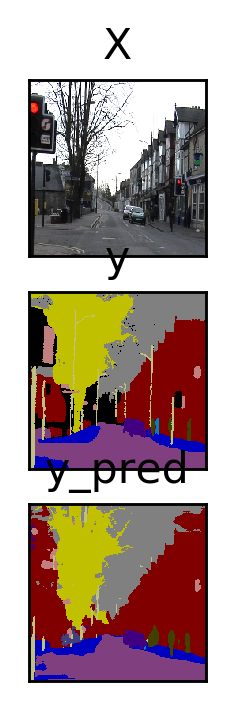

In [24]:
X, y, p = predict.predict(model, generators['test'], camvid11)
_ = camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

# Clear Session

remove the current model from memory.

In [25]:
from keras import backend as K
K.clear_session()

# Fine Tuning

In [26]:
camvid11 = camvid.CamVid(
    mapping=camvid.load_mapping(),
    target_size=target_size,
    crop_size=fine_crop,
    batch_size=fine_batch,
    horizontal_flip=True,
    ignored_labels=['Void'],
)
generators = camvid11.generators()

Found 367 images belonging to 1 classes.
Found 367 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 233 images belonging to 1 classes.
Found 233 images belonging to 1 classes.


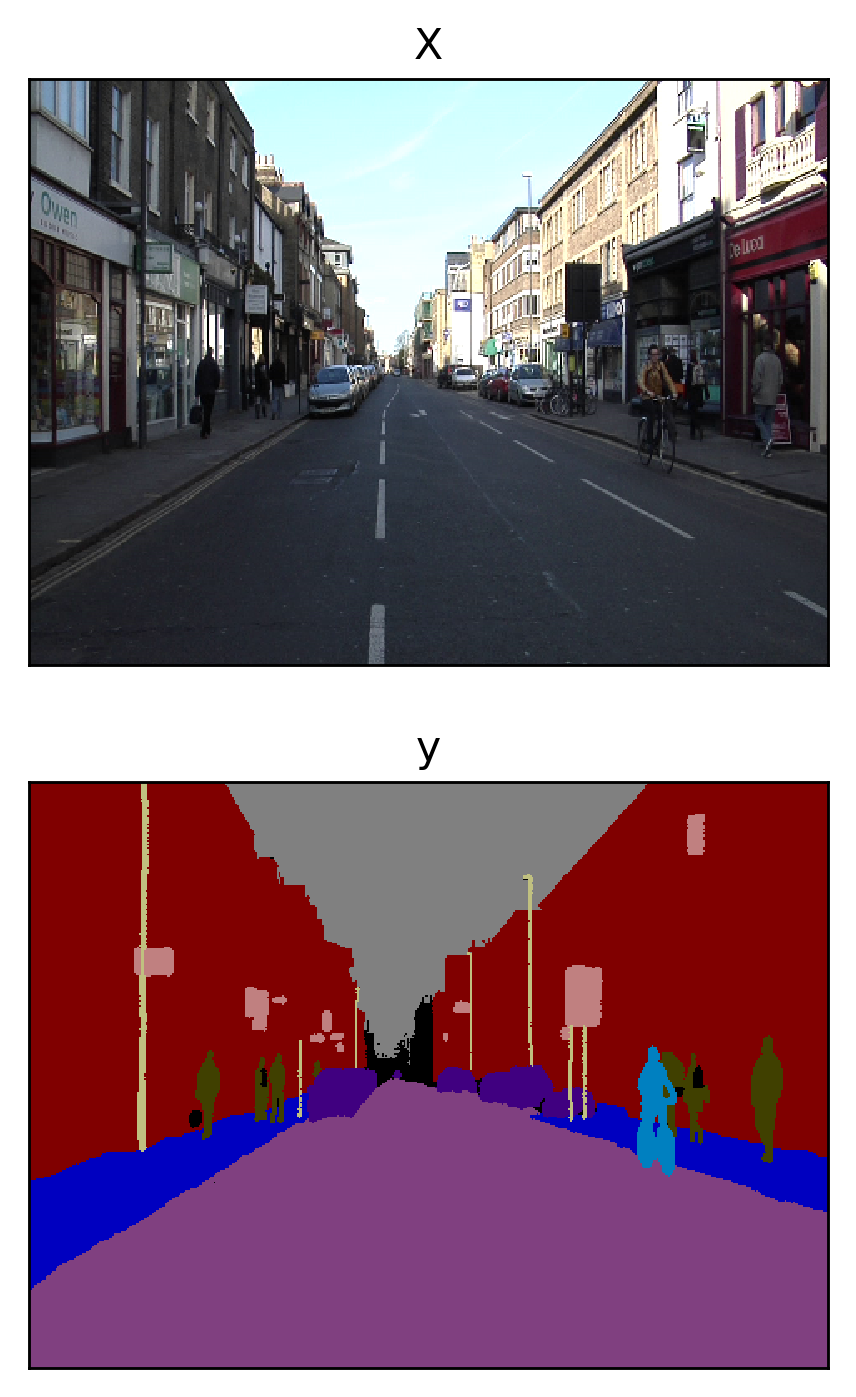

In [27]:
# get the next X, y training tuple
X, y = next(generators['train'])
# transform the onehot vector to an image
y = camvid11.unmap(y)
# plot the images
_ = camvid.plot(X=X[0], y=y[0], order=['X', 'y'])

In [28]:
# build the model for the image shape and number of labels
tune_model = tiramisu.tiramisu((*fine_crop, 3), camvid11.n,
    class_weights=camvid11.class_mask,
    learning_rate=1e-4,
)
# load the weights from the coarsely trained model
tune_model.load_weights(coarse_weights)
tune_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Tiramisu_input (InputLayer)     (None, 352, 480, 3)  0                                            
__________________________________________________________________________________________________
pixel_norm (Lambda)             (None, 352, 480, 3)  0           Tiramisu_input[0][0]             
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 352, 480, 48) 1344        pixel_norm[0][0]                 
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 352, 480, 48) 192         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

In [29]:
callbacks = [
    EarlyStopping(monitor='val_categorical_accuracy', patience=50),
    ModelCheckpoint(fine_weights, 
        monitor='val_categorical_accuracy', 
        save_best_only=True, 
        save_weights_only=True, 
        mode='max'
    ),
    PlotMetrics(),
]

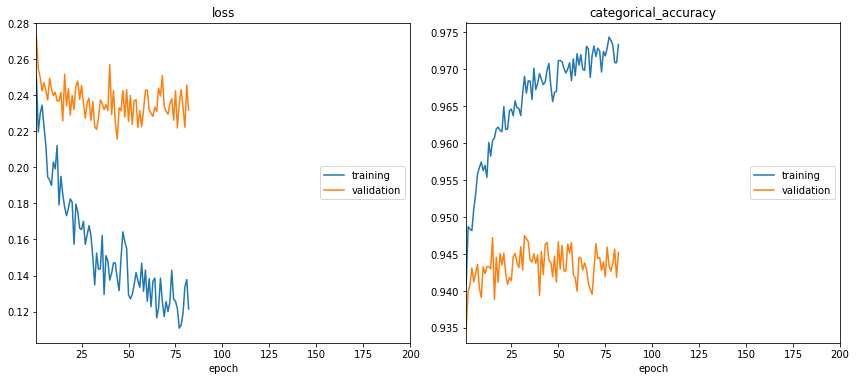

In [30]:
# fit the model with the data.
history = tune_model.fit_generator(generators['train'],
    epochs=200,
    steps_per_epoch=int(367 / fine_batch),
    validation_data=generators['val'],
    validation_steps=101,
    callbacks=callbacks,
    verbose=0,
)

In [31]:
history_to_results(history)

train       val
categorical_accuracy  0.973338  0.945193
loss                  0.121474  0.231633

## Test Metrics

In [32]:
tune_model.load_weights(fine_weights)

In [33]:
metrics = evaluate.evaluate(tune_model, generators['test'], 233,
    mask=camvid11.class_mask, 
    label_map=camvid11.label_to_discrete_map
)
metrics.to_csv(fine_weights + '.csv')
metrics

100%|██████████| 233/233 [01:20<00:00,  2.91step/s]


Test
Accuracy                 0.901727
Mean Per Class Accuracy  0.685065
Mean I/U                 0.567453
Bicyclist                0.332004
Building                 0.770349
Car                      0.668687
Column_Pole              0.257645
Fence                    0.247566
Pedestrian               0.429406
Road                     0.901876
Sidewalk                 0.769319
SignSymbol               0.221980
Sky                      0.921203
VegetationMisc           0.721953

In [34]:
print(tabulate(metrics, tablefmt='pipe', headers=('Metric', 'Value')))

| Metric                  |    Value |
|:------------------------|---------:|
| Accuracy                | 0.901727 |
| Mean Per Class Accuracy | 0.685065 |
| Mean I/U                | 0.567453 |
| Bicyclist               | 0.332004 |
| Building                | 0.770349 |
| Car                     | 0.668687 |
| Column_Pole             | 0.257645 |
| Fence                   | 0.247566 |
| Pedestrian              | 0.429406 |
| Road                    | 0.901876 |
| Sidewalk                | 0.769319 |
| SignSymbol              | 0.22198  |
| Sky                     | 0.921203 |
| VegetationMisc          | 0.721953 |


## Qualitative Results

### Train

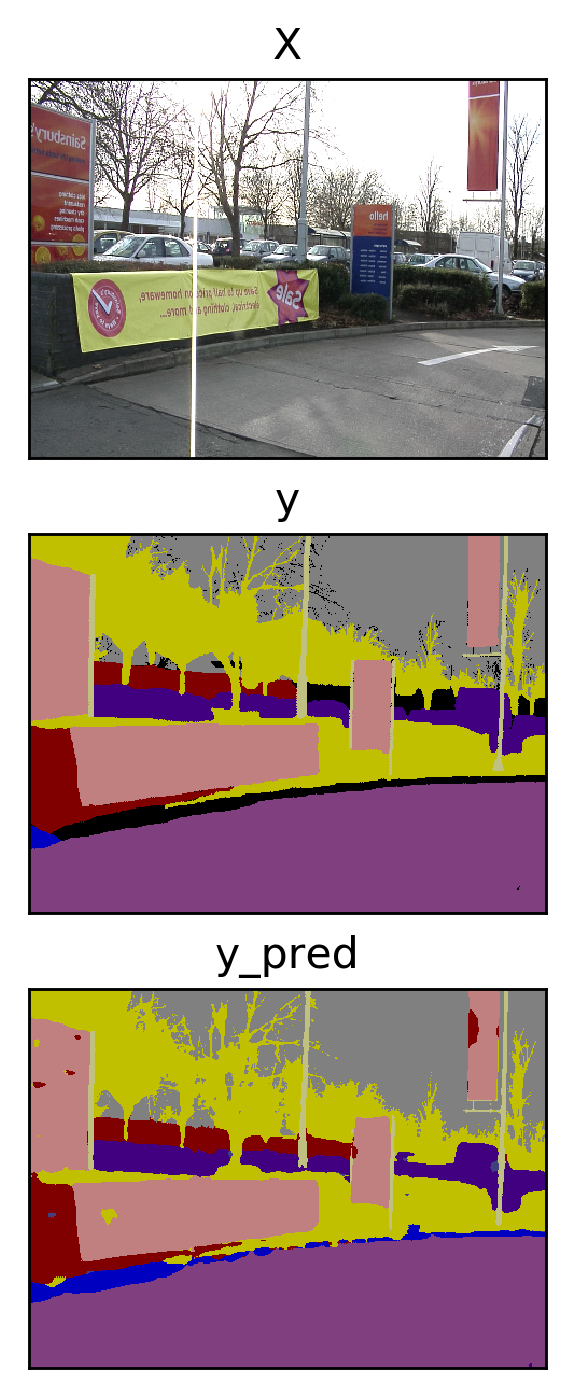

In [35]:
X, y, p = predict.predict(tune_model, generators['train'], camvid11)
_ = camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

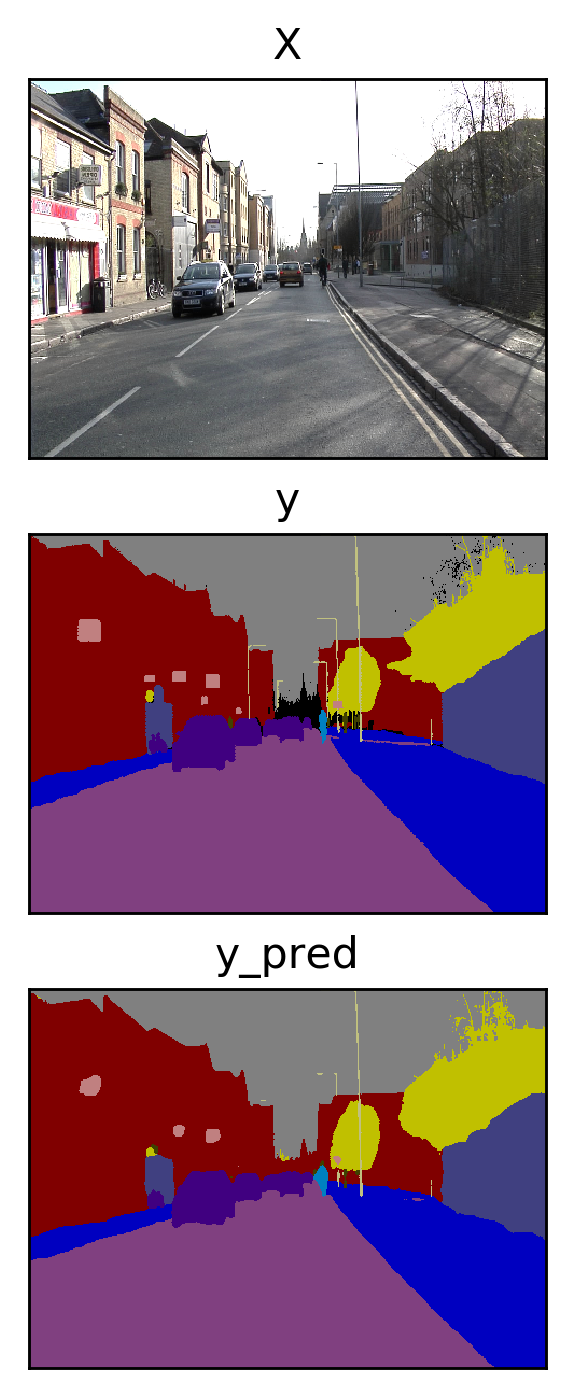

In [36]:
X, y, p = predict.predict(tune_model, generators['train'], camvid11)
_ = camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

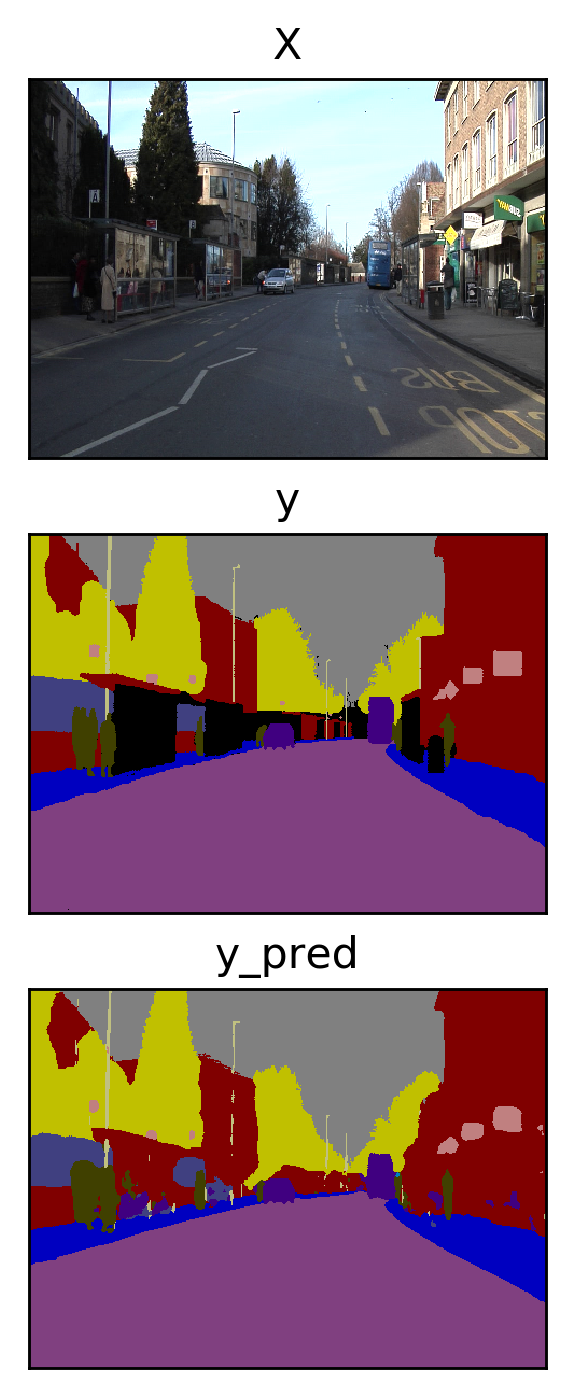

In [37]:
X, y, p = predict.predict(tune_model, generators['train'], camvid11)
_ = camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

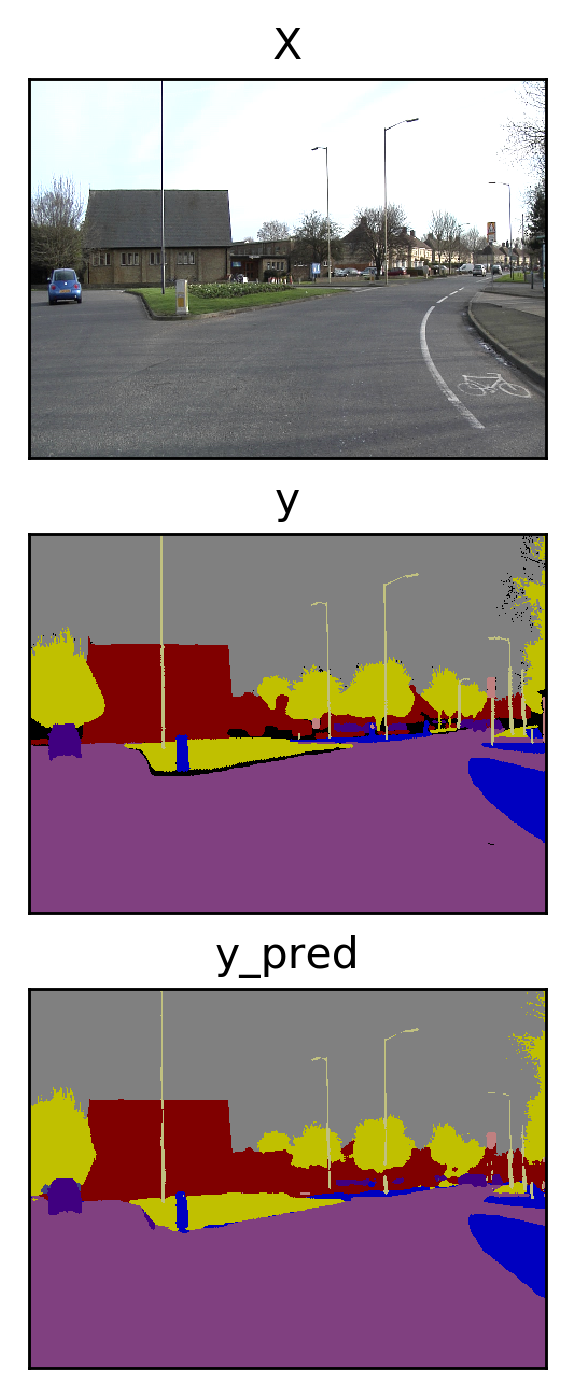

In [38]:
X, y, p = predict.predict(tune_model, generators['train'], camvid11)
_ = camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

### Validation

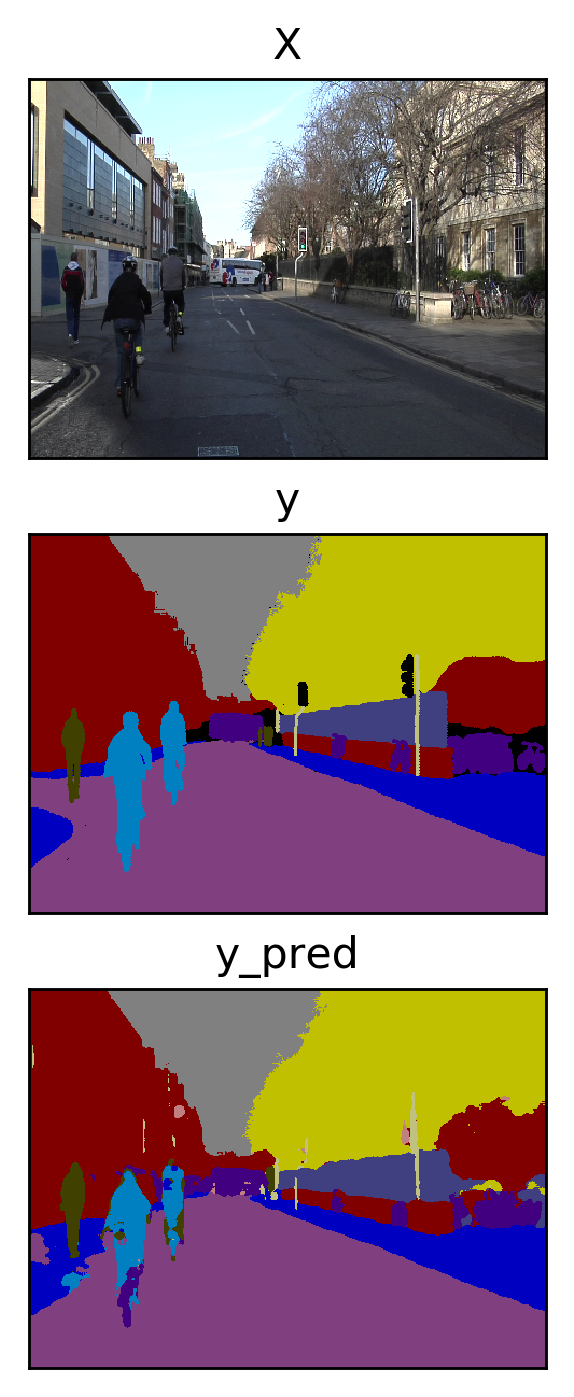

In [39]:
X, y, p = predict.predict(tune_model, generators['val'], camvid11)
_ = camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

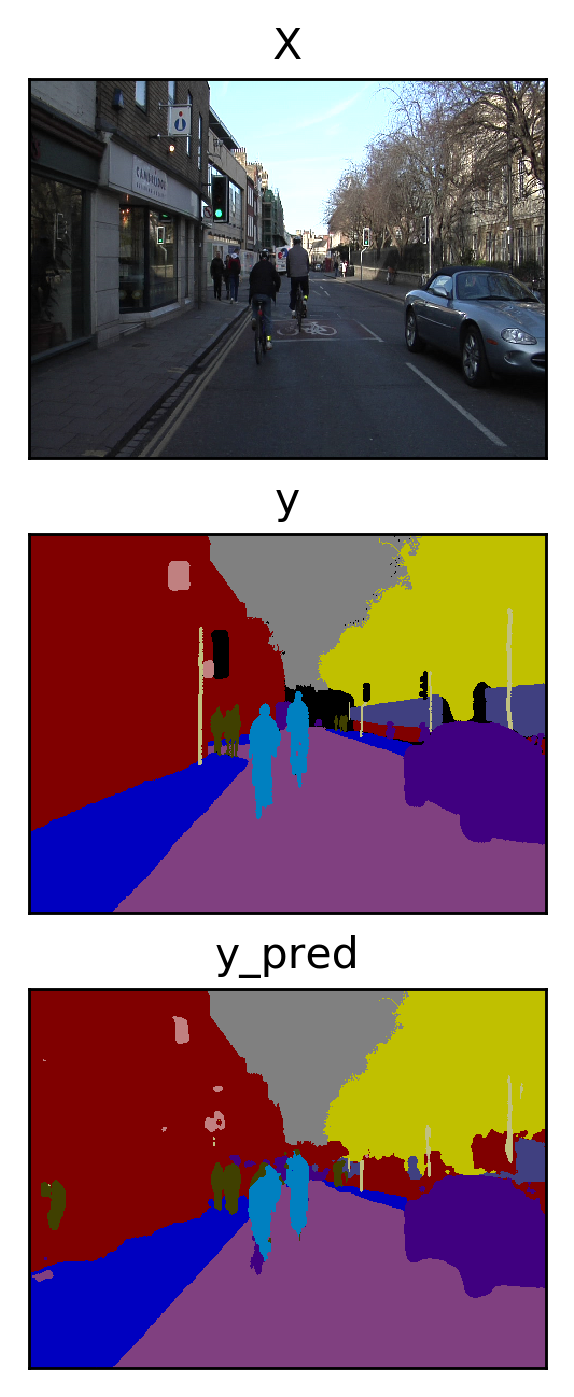

In [40]:
X, y, p = predict.predict(tune_model, generators['val'], camvid11)
_ = camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

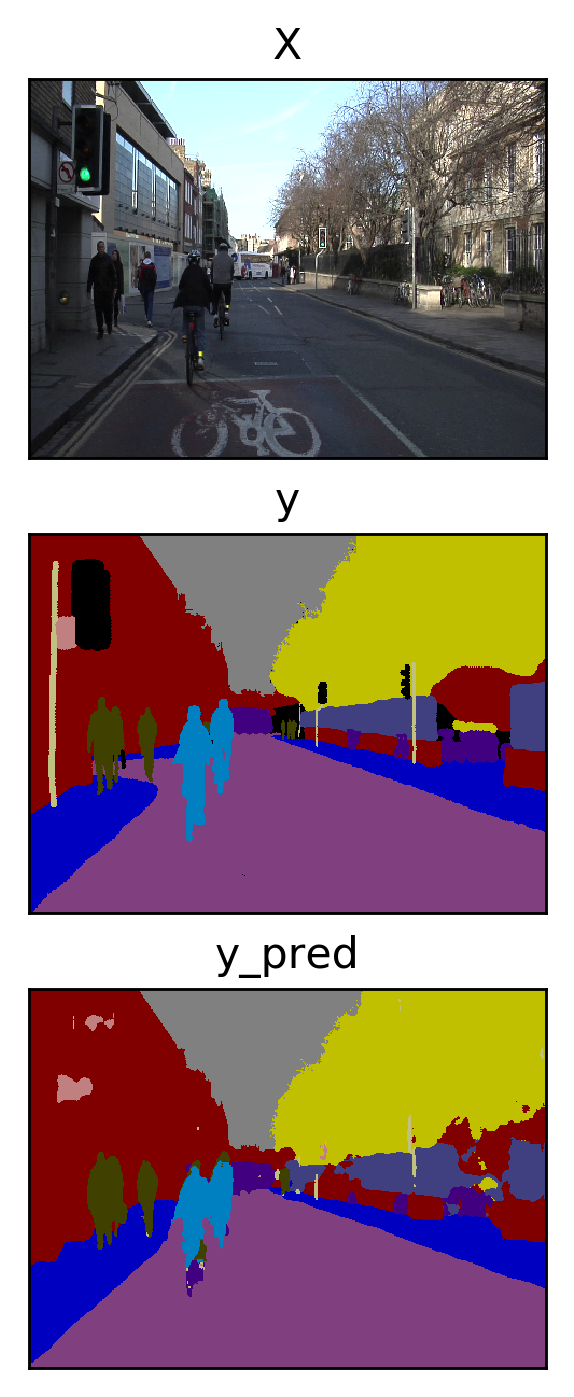

In [41]:
X, y, p = predict.predict(tune_model, generators['val'], camvid11)
_ = camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

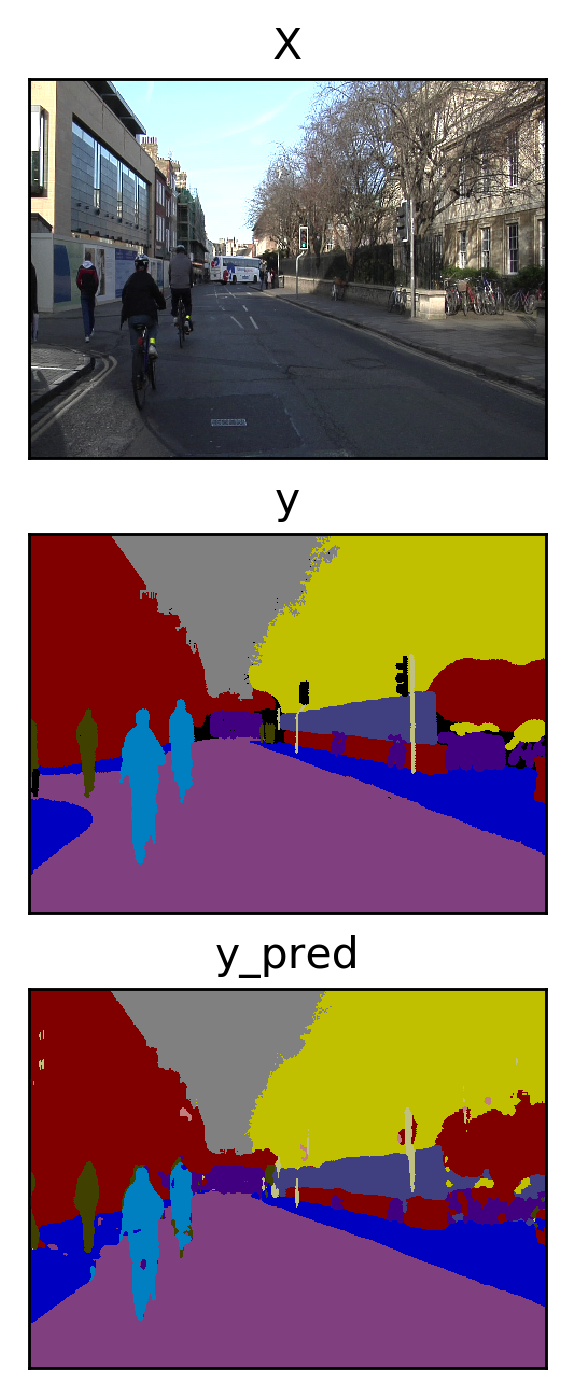

In [42]:
X, y, p = predict.predict(tune_model, generators['val'], camvid11)
_ = camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

### Test

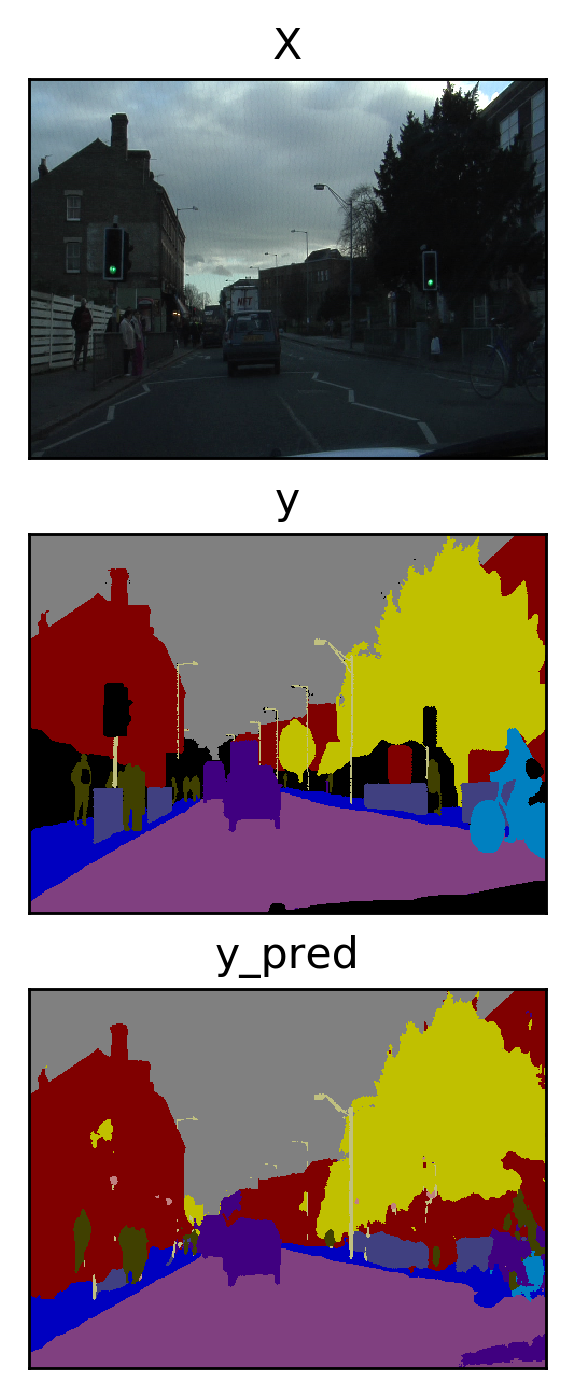

In [43]:
X, y, p = predict.predict(tune_model, generators['test'], camvid11)
fig = camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])
fig.savefig('img/tiramisu/0.png', transparent=True, bbox_inches='tight')

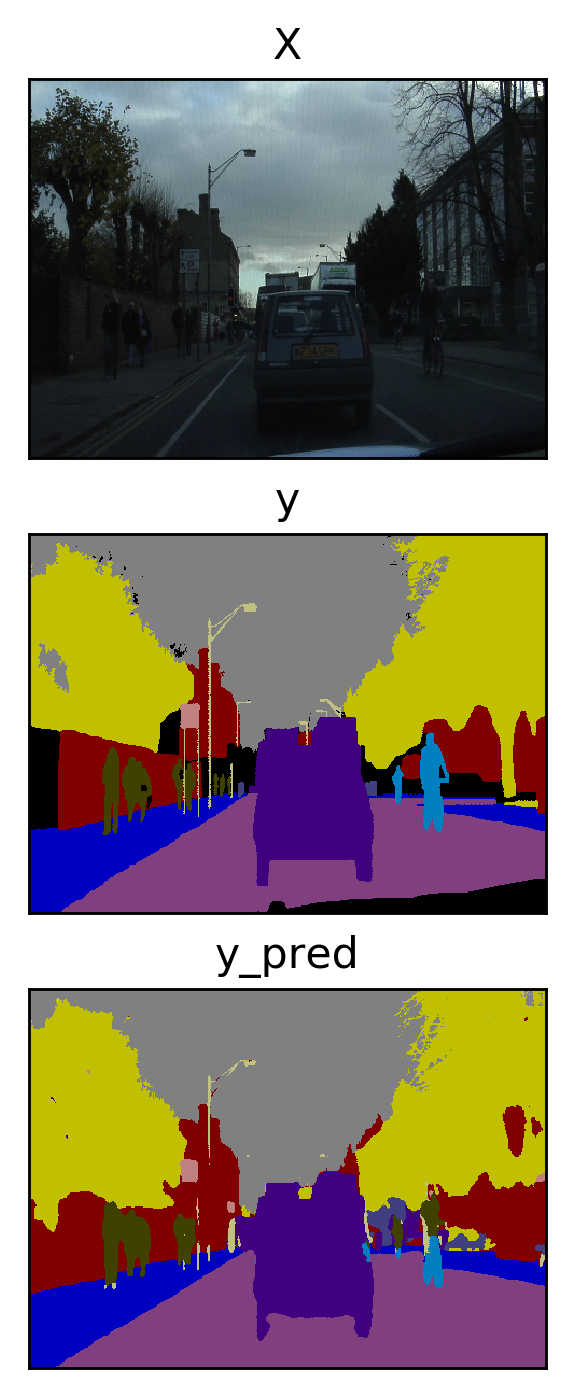

In [44]:
X, y, p = predict.predict(tune_model, generators['test'], camvid11)
fig = camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])
fig.savefig('img/tiramisu/1.png', transparent=True, bbox_inches='tight')

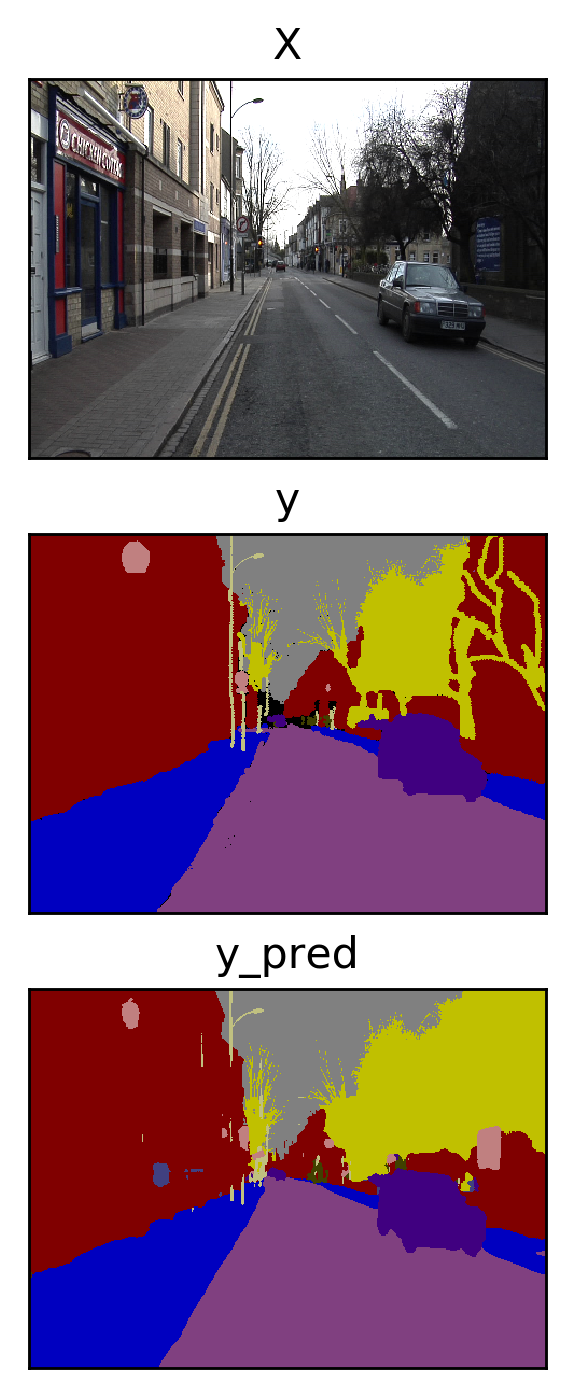

In [45]:
X, y, p = predict.predict(tune_model, generators['test'], camvid11)
fig = camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])
fig.savefig('img/tiramisu/2.png', transparent=True, bbox_inches='tight')

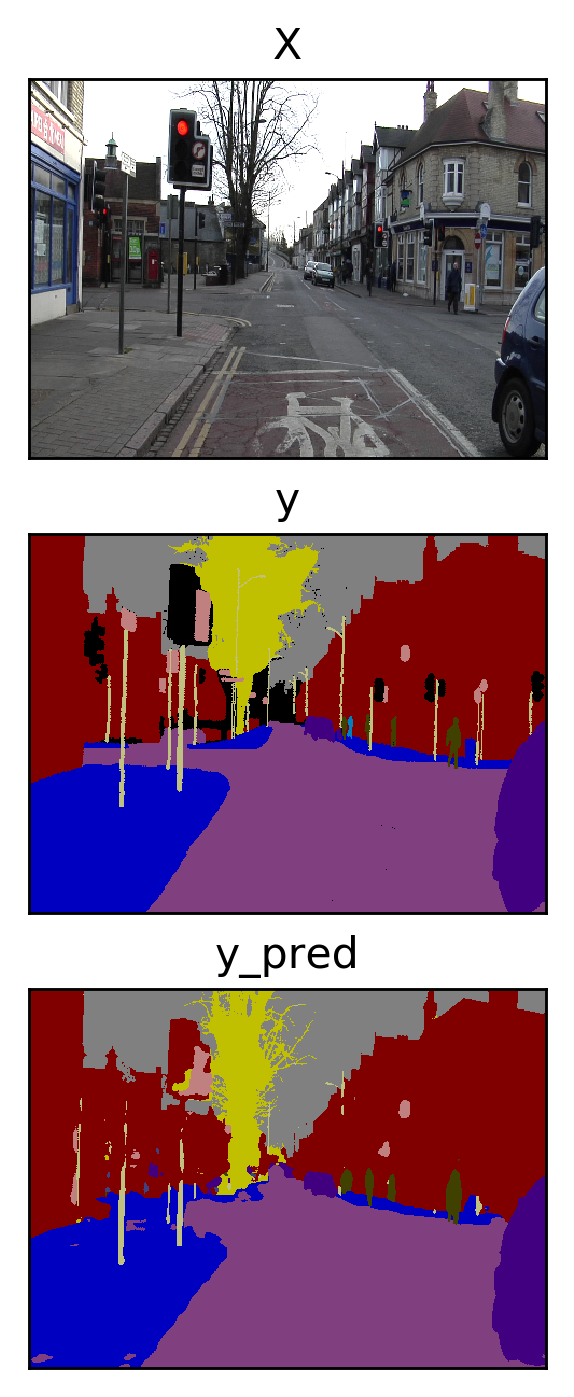

In [46]:
X, y, p = predict.predict(tune_model, generators['test'], camvid11)
fig = camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])
fig.savefig('img/tiramisu/3.png', transparent=True, bbox_inches='tight')

# Video

In [47]:
video_file = '0005VD.mp4'
video_path = camvid.videos.abs_path(video_file)
out_path = 'img/tiramisu/{}'.format(video_file)

In [48]:
predict_video.predict_video(video_path, out_path, camvid11, tune_model, predict.predict)

100%|██████████| 6600/6600 [26:09<00:00,  4.20it/s]
